**Importing all the libraires we are going to use**

In [1]:
import os
import scipy
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from scipy import stats
import pickle
from statsmodels.stats.proportion import proportion_confint
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels
import itertools
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Lets change the directory to our files
PATH_TO_DATA = '/content/drive/MyDrive/Colab_Notebooks/User_Identify/Data_Files'

**Let's look at one of the files with data about the web pages visited by the user (number 1).**

In [ ]:
look = pd.read_csv(os.path.join(PATH_TO_DATA, '3users/user0001.csv'))
look.head()

,timestamp,site
0,2013-11-15 09:28:17,vk.com
1,2013-11-15 09:33:04,oracle.com
2,2013-11-15 09:52:48,oracle.com
3,2013-11-15 11:37:26,geo.mozilla.org
4,2013-11-15 11:40:32,oracle.com


**Lets set a classification task: to identify user by 10 visited websites in a row. So the object in this task will be the 10 websites session visited by one user successively, signs will be indexes of that 10 sites. Targetive class - user id.**

##**Part 1. Training data preparation**

**The function below gets in path to file catalogue and parameter session lengths which is 10 by default and gives out prepared DataFrame and vocabulary of websites frequencies**

In [ ]:
def prepare_train_set(path_to_csv_files, session_length=10):
    #Getting the list of all files in directory
    list1 = os.listdir(path_to_csv_files)
    sites = {}
    site_id = 1
    sess_id = 0
    flagE = False
    #Initializing for loop for every file
    for pathh in list1:
        #Working only on csv files
        if 'csv' in pathh:
            file1 = pd.read_csv(os.path.join(path_to_csv_files, pathh), sep=',')
            #Checking if quantity of websites divides by 10, so we don`t need to add zeros in the end of the session
            if file1.shape[0]%10 == 0:
                sessionss = np.zeros((file1.shape[0]//10, 12))
                for j in range(file1.shape[0]//10):
                    sessionss[j][0] = sess_id
                    sess_id += 1  
            else:
                sessionss = np.zeros(((file1.shape[0]//10) + 1, 12))
                for j in range((file1.shape[0]//10) + 1):
                    sessionss[j][0] = sess_id
                    sess_id += 1 
            #Creating and updating vocabulary of frequencies
            for i in range(file1.shape[0]):
                if file1['site'][i] in sites:
                    sites[file1['site'][i]] = (sites[file1['site'][i]][0], sites[file1['site'][i]][1] + 1)
                else:
                    sites[file1['site'][i]] = (site_id, 1) 
                    site_id += 1      
                sessionss[i//10][(i%10)+1] = sites[file1['site'][i]][0]
                sessionss[i//10][11] = int(pathh[4:8])
            if flagE == False:
                sessions = sessionss
                flagE = True
            else:
                sessions = np.append(sessions, sessionss, axis=0)
    coll = ['sess_id', 'site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10', 'user_id']
    sessions = pd.DataFrame(sessions, columns=coll, dtype='int')
    sessions.index = sessions.sess_id
    sessions.drop('sess_id', axis = 1, inplace=True)
    
    return sessions, sites

**This function is just a baseline, the first attempt, which works really slow, we will improve it later**

Let`s take a look on the first three users files

In [ ]:
!cat '/content/drive/MyDrive/Colab_Notebooks/User_Identify/Data_Files/3users/user0001.csv'

timestamp,site
2013-11-15 09:28:17,vk.com
2013-11-15 09:33:04,oracle.com
2013-11-15 09:52:48,oracle.com
2013-11-15 11:37:26,geo.mozilla.org
2013-11-15 11:40:32,oracle.com
2013-11-15 11:40:34,google.com
2013-11-15 11:40:35,accounts.google.com
2013-11-15 11:40:37,mail.google.com
2013-11-15 11:40:40,apis.google.com
2013-11-15 11:41:35,plus.google.com
2013-11-15 12:40:35,vk.com
2013-11-15 12:40:37,google.com
2013-11-15 12:40:40,google.com
2013-11-15 12:41:35,google.com


In [ ]:
!cat '/content/drive/MyDrive/Colab_Notebooks/User_Identify/Data_Files/3users/user0002.csv'

timestamp,site
2013-11-15 09:28:17,vk.com
2013-11-15 09:33:04,oracle.com
2013-11-15 09:52:48,football.kulichki.ru
2013-11-15 11:37:26,football.kulichki.ru
2013-11-15 11:40:32,oracle.com


In [ ]:
!cat '/content/drive/MyDrive/Colab_Notebooks/User_Identify/Data_Files/3users/user0003.csv'

timestamp,site
2013-11-15 09:28:17,meduza.io
2013-11-15 09:33:04,google.com
2013-11-15 09:52:48,oracle.com
2013-11-15 11:37:26,google.com
2013-11-15 11:40:32,oracle.com
2013-11-15 11:40:34,google.com
2013-11-15 11:40:35,google.com
2013-11-15 11:40:37,mail.google.com
2013-11-15 11:40:40,yandex.ru
2013-11-15 11:41:35,meduza.io
2013-11-15 12:28:17,meduza.io
2013-11-15 12:33:04,google.com
2013-11-15 12:52:48,oracle.com


**Trying our function on 3 files just to see if it works properly**

In [ ]:
train_data_toy, site_freq_3users = prepare_train_set('/content/drive/My Drive/Colab_Notebooks/User_Identify/Data_Files/3users', 
                                                     session_length=10)

In [ ]:
train_data_toy.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
sess_id,,,,,,,,,,,
0,1,2,2,3,2,4,5,6,7,8,1
1,1,4,4,4,0,0,0,0,0,0,1
2,1,2,9,9,2,0,0,0,0,0,2
3,10,4,2,4,2,4,4,6,11,10,3
4,10,4,2,0,0,0,0,0,0,0,3


In [ ]:
site_freq_3users

{'accounts.google.com': (5, 1),
 'apis.google.com': (7, 1),
 'football.kulichki.ru': (9, 2),
 'geo.mozilla.org': (3, 1),
 'google.com': (4, 9),
 'mail.google.com': (6, 2),
 'meduza.io': (10, 3),
 'oracle.com': (2, 8),
 'plus.google.com': (8, 1),
 'vk.com': (1, 3),
 'yandex.ru': (11, 1)}

**Applying our function to 10 users**

In [ ]:
%%time
train_data_10users, site_freq_10users = prepare_train_set(os.path.join(PATH_TO_DATA, '10users/'),session_length=10)

CPU times: user 4.76 s, sys: 19.2 ms, total: 4.78 s
Wall time: 7.47 s


In [ ]:
#Lets see how many unique sessions are and how many unique sites 10 users have visited
print('Total sessions quantity: {}, Number of unique sites: {}'.format(train_data_10users.shape[0], len(site_freq_10users)))

Total sessions quantity: 14061, Number of unique sites: 4913


**Let`s apply this function to 150 users**

In [ ]:
%%time
train_data_150users, site_freq_150users = prepare_train_set(os.path.join(PATH_TO_DATA, '150users/'))

CPU times: user 47.4 s, sys: 312 ms, total: 47.7 s
Wall time: 1min 24s


In [ ]:
print('Total sessions quantity: {}, Number of unique sites: {}'.format(train_data_150users.shape[0], len(site_freq_150users)))

Total sessions quantity: 137019, Number of unique sites: 27797


**Lets save our train datasets**

In [ ]:
pd.

**10 most visited websites**

In [ ]:
sorted(site_freq_150users.items(), key=lambda x: x[1][1], reverse=True)[:10]

[('www.google.fr', (2, 64785)),
 ('www.google.com', (4, 51320)),
 ('www.facebook.com', (9, 39002)),
 ('apis.google.com', (3, 29983)),
 ('s.youtube.com', (385, 29102)),
 ('clients1.google.com', (139, 25087)),
 ('mail.google.com', (43, 19072)),
 ('plus.google.com', (47, 18467)),
 ('safebrowsing-cache.google.com', (614, 17960)),
 ('www.youtube.com', (229, 16319))]

##**Part 2. Working with sparse data.**

In [ ]:
#Let`s split our data
X_toy, y_toy = train_data_toy.iloc[:, :-1].values, train_data_toy.iloc[:, -1].values

In [ ]:
X_toy

array([[ 1,  2,  2,  3,  2,  4,  5,  6,  7,  8],
       [ 1,  4,  4,  4,  0,  0,  0,  0,  0,  0],
       [ 1,  2,  9,  9,  2,  0,  0,  0,  0,  0],
       [10,  4,  2,  4,  2,  4,  4,  6, 11, 10],
       [10,  4,  2,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
y_toy

array([1, 1, 2, 3, 3])

In [9]:
#Function prepare raw data before we make it sparse
def csr_prepare(docss):
    docs = docss
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in docs:
        for term in d:
            index = term
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    return(data, indices, indptr)

In [ ]:
data_toy, indices_toy, indptr_toy = csr_prepare(X_toy)
#Also removing first column as it will show our zeros which we added to Data Set to not to be Null
X_sparse_toy = csr_matrix((data_toy, indices_toy, indptr_toy), dtype=int)[:,1:]

In [ ]:
X_sparse_toy.todense()

matrix([[1, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0],
        [0, 2, 0, 4, 0, 1, 0, 0, 0, 2, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]])

**Matrix`s dimensionality is 11 that matches with number of unique websites. So now we have something similar to Bag of Words and this form of data is more useful than just an ids of websites.**

**Let`s save this sparse matrix and vocabularies**

In [ ]:
X_10users, y_10users = train_data_10users.iloc[:, :-1].values, \
                       train_data_10users.iloc[:, -1].values
X_150users, y_150users = train_data_150users.iloc[:, :-1].values, \
                         train_data_150users.iloc[:, -1].values

In [ ]:
X_sparse_10users = csr_matrix((csr_prepare(X_10users)), dtype=int)[:,1:]
X_sparse_150users = csr_matrix((csr_prepare(X_150users)), dtype=int)[:,1:]

In [ ]:
scipy.sparse.save_npz(os.path.join(PATH_TO_DATA, 
                                   'Pickles/X_sparse_10users.npz'), X_sparse_10users)
with open(os.path.join(PATH_TO_DATA, 'Pickles/y_10users.txt'), 'w') as filet:
    for i in y_10users:
        filet.write(str(i)+'\n')
        
scipy.sparse.save_npz(os.path.join(PATH_TO_DATA, 
                                   'Pickles/X_sparse_150users.npz'), X_sparse_150users)
with open(os.path.join(PATH_TO_DATA, 'Pickles/y_150users.txt'), 'w') as filet:
    for i in y_150users:
        filet.write(str(i)+'\n')

with open(os.path.join(PATH_TO_DATA, 
                       'Pickles/site_freq_3users.pkl'), 'wb') as site_freq_3users_pkl:
    pickle.dump(site_freq_3users, site_freq_3users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'Pickles/site_freq_10users.pkl'), 'wb') as site_freq_10users_pkl:
    pickle.dump(site_freq_10users, site_freq_10users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'Pickles/site_freq_150users.pkl'), 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl, protocol=2)

**Just checking if dimensionality of sparse matrixes matches with length of frequencies vocabulary**

In [ ]:
X_sparse_10users.shape[1] == len(site_freq_10users)

True

In [ ]:
X_sparse_150users.shape[1] == len(site_freq_150users)

True

##**Part 3. Preparing multiple training samples for comparison**

**Let`s modify the function from week 1 to be able to prepare sparse matrix for a different sessions length and window size**

**So the next function will take in path to files catalogue, path to frequencies vocabulary, parameter session length and window size and give out sparse matrix and vector of "answers".**

In [ ]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    
    #Reading frequencies dictionary
    with open(os.path.join(PATH_TO_DATA, site_freq_path), 'rb') as pickles:
        freq_dict = pickle.load(pickles)
    upd_path = PATH_TO_DATA + path_to_csv_files
    #Getting the list of all files in directory
    list_path = os.listdir(upd_path)
    empty_flag = True
    sessions_gen = []
    y_label = []
    #Going step by step in every file from he list
    for item in list_path:
        flag2 = True
        #Working with inly csv files
        if 'csv' in item:
            csv1 = pd.read_csv(os.path.join(upd_path, item))
            sessions_user = []
            #Passing every line in the file and adding it to flatten session`s array
            for element in csv1.site:
                sessions_user = np.append(sessions_user, freq_dict[element][0])
            #Checking if we can just reshape the array
            if session_length == window_size:
                #Adding some zeros in the end of array
                if len(sessions_user)%window_size != 0:
                    sessions_user = np.append(sessions_user, [0]*(session_length - (len(sessions_user)%window_size)))
            else:
                sess_test = []
                if len(sessions_user)%window_size == 0:
                    temp = np.append(sessions_user, [0]*session_length)
                    #forming array regarding to windows size
                    for i in range(len(sessions_user)//window_size):
                        sess_test = np.append(sess_test, temp[i*window_size:(i*window_size + session_length)])
                else:
                    temp = np.append(sessions_user, [0]*session_length)
                    for i in range(len(sessions_user)//window_size + 1):
                        sess_test = np.append(sess_test, temp[i*window_size:(i*window_size + session_length)])
                sessions_user = sess_test.copy()
            #Appending every user to a general array
            sessions_gen = np.append(sessions_gen, sessions_user)
            y_label = np.append(y_label, (len(sessions_user)//session_length)*[int(item[4:8])])
    #Preparing parameters to sparse
    data = len(sessions_gen)*[1]
    indptr = [session_length*i for i in range(len(sessions_gen)//session_length + 1)]
    indices = sessions_gen
    #Making sparse matrix
    data_toy = csr_matrix((data, indices, indptr), dtype=int)[:,1:]

    #Kind of progress bar
    print('DONE_num{0}_sess{1}_window{2}'.format(path_to_csv_files[:3], session_length, window_size))
    return data_toy, y_label

**Lets try using this new function on the toy sample with 3 users**

In [ ]:
X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(os.path.join('3users'), 
                                                       os.path.join('Pickles/site_freq_3users.pkl'),
                                       session_length=5, window_size=3)

DONE_num3us_sess5_window3


In [ ]:
X_toy_s5_w3.todense()

matrix([[1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 3, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
y_s5_w3

array([1., 1., 1., 1., 1., 2., 2., 3., 3., 3., 3., 3.])

**Now lets use this function to create several new sparse matrixes with different session lengths and windows sizes**

In [ ]:
%%time

data_lengths = {}

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            #Preparing samples
            X_sparse, y = prepare_sparse_train_set_window('{}users'.format(num_users), 'Pickles/site_freq_{}users.pkl'.format(num_users),
                                                          session_length=session_length, window_size=window_size)
            
            
            data_lengths['{}users_session{}_window{}'.format(num_users, session_length, window_size)] = X_sparse.shape[0]
            #Saving sparse matrix to file
            scipy.sparse.save_npz(os.path.join(PATH_TO_DATA, 'Pickles/X_sparse_{0}users_s{1}_w{2}.npz'.format(num_users, session_length, window_size)), X_sparse)
            #Saving "answers"
            with open(os.path.join(PATH_TO_DATA, 'Pickles/y_{0}users_s{1}_w{2}.txt'.format(num_users, session_length, window_size)), 'w') as filet:
                for i in y:
                    filet.write(str(i)+'\n')

DONE_num10u_sess15_window10
DONE_num10u_sess15_window7
DONE_num10u_sess10_window7
DONE_num10u_sess7_window7
DONE_num10u_sess15_window5
DONE_num10u_sess10_window5
DONE_num10u_sess7_window5
DONE_num10u_sess5_window5
DONE_num150_sess15_window10
DONE_num150_sess15_window7
DONE_num150_sess10_window7
DONE_num150_sess7_window7
DONE_num150_sess15_window5
DONE_num150_sess10_window5
DONE_num150_sess7_window5
DONE_num150_sess5_window5
CPU times: user 2min 27s, sys: 3.15 s, total: 2min 30s
Wall time: 2min 33s


**Lets have a look how many sessions we got with different configurations**

In [ ]:
data_lengths

{'10users_session10_window5': 28118,
 '10users_session10_window7': 20087,
 '10users_session15_window10': 14061,
 '10users_session15_window5': 28118,
 '10users_session15_window7': 20087,
 '10users_session5_window5': 28118,
 '10users_session7_window5': 28118,
 '10users_session7_window7': 20087,
 '150users_session10_window5': 273957,
 '150users_session10_window7': 195712,
 '150users_session15_window10': 137019,
 '150users_session15_window5': 273957,
 '150users_session15_window7': 195712,
 '150users_session5_window5': 273957,
 '150users_session7_window5': 273957,
 '150users_session7_window7': 195712}

##**Part 4. Initial data analysis and hypothesis testing**

**Lets use prepared earlier sample train_data_10users**

In [ ]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
sess_id,,,,,,,,,,,
0,1,2,3,4,3,3,4,3,5,3,31
1,6,7,8,9,3,10,11,12,13,14,31
2,14,4,14,14,15,16,6,17,18,14,31
3,19,20,19,14,14,14,14,21,22,23,31
4,24,14,15,25,26,27,28,29,30,29,31


In [ ]:
train_data_10users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   site1    14061 non-null  int64
 1   site2    14061 non-null  int64
 2   site3    14061 non-null  int64
 3   site4    14061 non-null  int64
 4   site5    14061 non-null  int64
 5   site6    14061 non-null  int64
 6   site7    14061 non-null  int64
 7   site8    14061 non-null  int64
 8   site9    14061 non-null  int64
 9   site10   14061 non-null  int64
 10  user_id  14061 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


In [ ]:
train_data_10users['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

**Let's calculate the distribution of the number of unique sites in each session out of 10 sites visited in a row.**

In [ ]:
num_unique_sites = [np.unique(train_data_10users.values[i, :-1]).shape[0] 
                    for i in range(train_data_10users.shape[0])]

pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

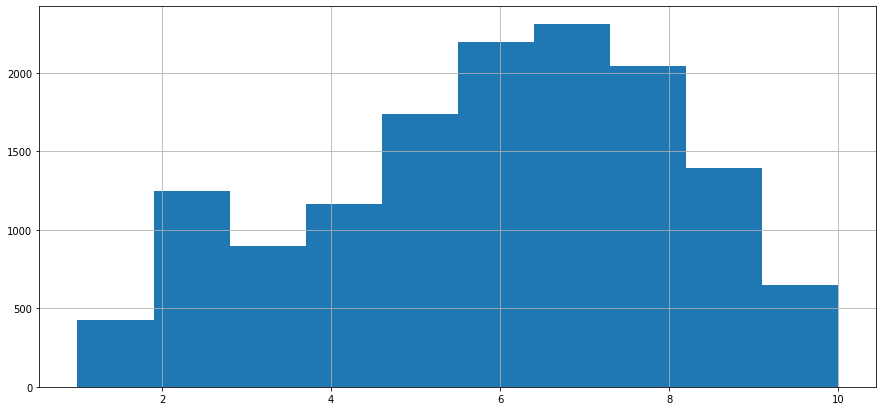

In [ ]:
plt.figure(figsize=((15, 7)))
pd.Series(num_unique_sites).hist();

**Lets check using QQ-plot and Shapiro Wilk criteria that this value has normal distribution**

((array([-3.89403843, -3.6734386 , -3.55253248, ...,  3.55253248,
          3.6734386 ,  3.89403843]), array([ 1,  1,  1, ..., 10, 10, 10])),
 (2.308739910778148, 5.951923760756702, 0.9770787039552055))

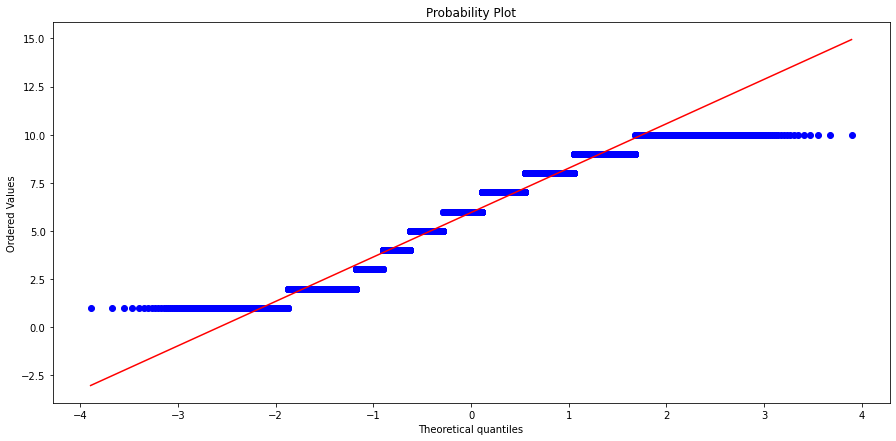

In [ ]:
plt.figure(figsize=((15, 7)))
stats.probplot(num_unique_sites, plot=plt)

In [ ]:
stat, p = stats.shapiro(num_unique_sites)
print('Statistics = %.3f, p = %.5f' % (stat, p))

Statistics = 0.955, p = 0.00000


**P-value is less then 0.05 so we can overturn the null hypothesis about normality of our distribution**

**Let's test the hypothesis that a user will visit a site at least once that he has previously visited in a session of 10 sites. Let's check using the binomial criterion for the maximum percentage of cases when a user revisited a site (that is, the number of unique sites in a session <10) is large: more than 95%.**

In [ ]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
pi_val = stats.binom_test(has_two_similar.sum(), len(has_two_similar), p=0.95, alternative='greater')
print('p-value = {}'.format(round(pi_val, 3)))

p-value = 0.022


**So we can overturn the hypothesis that the customer with 95% possibility will visit website again inside one session**

**Lets see on 95% Wilson`s confidence interval for that proportion**

In [ ]:
wilson_interval = proportion_confint(has_two_similar.sum(), len(has_two_similar), method='wilson')
print('95% confidence interval: [{}:{}]'.format(round(wilson_interval[0], 3), round(wilson_interval[1], 3)))

95% confidence interval: [0.95:0.957]


**Lets draw a distribution of frequencies visited websites which have been visited more than 1000 times**

<BarContainer object of 25 artists>

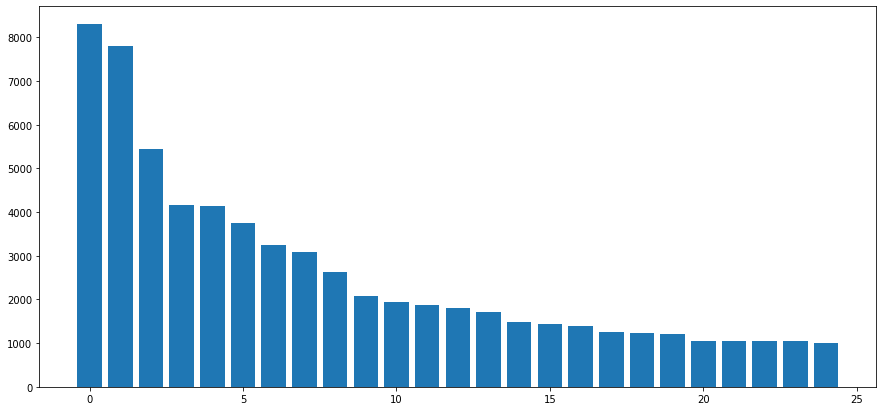

In [ ]:
site_freqs = sorted(site_freq_10users.items(), key=lambda x: x[1][1], reverse=True)
site_freqs1= [x[1][1] for x in site_freqs if x[1][1] > 1000]
plt.figure(figsize=((15, 7)))
plt.bar([x for x in range(len(site_freqs1))], site_freqs1)

**Lets plot a 95% confidence interval for the average frequency of the site appearance in the sample (in the whole, not just for those sites that have been visited at least 1000 times) based on bootstrap. Use as many bootstrap subsamples as there were sites in the original sample of 10 users. Take subsamples from the calculated list of frequencies of visits to sites - no need to re-count these frequencies. Please note that the frequency of occurrence of zero (site with index 0 appeared where sessions were shorter than 10 sites) do not need to be included.**

In [ ]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
inds, freqs = zip(*([x[1] for x in site_freqs]))
freqs = np.reshape(freqs, newshape=(len(freqs), 1))
pre_data_df = pd.DataFrame(freqs, index=inds, columns=['Freqs'])

freqs_mean_scores = list(map(np.mean, get_bootstrap_samples(pre_data_df.Freqs.values, pre_data_df.shape[0])))

l, r = stat_intervals(freqs_mean_scores, alpha=0.05)

print('Confidence interval: [{}:{}]'.format(round(l,3), round(r ,3)))

Confidence interval: [22.515:35.763]


##**Part 5. Feature engineering**

**Lets create a new function based on previous ones. We will create next features:**
- `session_timespan` - session duration
- `#unique_sites` - number of unique sites in session
- `start_hour` - hour when session started
- `day_of_week` - day of week when session started

So the function should give out DataFrame but with more features

In [ ]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names=None,
                                    session_length=10, window_size=10):
    with open(os.path.join(PATH_TO_DATA, site_freq_path), 'rb') as pickles:
        freq_dict = pickle.load(pickles)
    upd_path = PATH_TO_DATA + path_to_csv_files
    list_path = os.listdir(upd_path)
    empty_flag = True
    sessions_gen = []
    time_stamp_g = []
    y_label = []
    for item in list_path:
        flag2 = True
        if 'csv' in item:
            csv1 = pd.read_csv(os.path.join(upd_path, item))
            csv1.timestamp = pd.to_datetime(csv1.timestamp)
            sessions_user = []
            time_stamp_u = []
            for ts, ws in csv1.itertuples(index=False, name=None):
                sessions_user = np.append(sessions_user, freq_dict[ws][0])
                time_stamp_u = np.append(time_stamp_u, ts)
            if session_length == window_size:
                if len(sessions_user)%window_size != 0:
                    sessions_user = np.append(sessions_user, [0]*(session_length - (len(sessions_user)%window_size)))
                    time_stamp_u = np.append(time_stamp_u, [time_stamp_u[-1]]*(session_length -(len(time_stamp_u)%window_size)))
            else:
                sess_test = []
                sess_test_ts = []
                if len(sessions_user)%window_size == 0:
                    temp = np.append(sessions_user, [0]*session_length)
                    temp1 = np.append(time_stamp_u, [0]*session_length)
                    for i in range(len(sessions_user)//window_size):
                        sess_test = np.append(sess_test, temp[i*window_size:(i*window_size + session_length)])
                        sess_test_ts = np.append(sess_test_ts, temp1[i*window_size:(i*window_size + session_length)])
                else:
                    temp = np.append(sessions_user, [0]*session_length)
                    temp1 = np.append(time_stamp_u, [0]*session_length)
                    for i in range(len(sessions_user)//window_size + 1):
                        sess_test = np.append(sess_test, temp[i*window_size:(i*window_size + session_length)])
                        sess_test_ts = np.append(sess_test_ts, temp1[i*window_size:(i*window_size + session_length)])
                sessions_user = sess_test.copy()
                time_stamp_u = sess_test_ts.copy()
            if empty_flag:
                sessions_gen = sessions_user.reshape((len(sessions_user)//session_length), session_length)
                time_stamp_g = time_stamp_u.reshape((len(sessions_user)//session_length), session_length)
                empty_flag = False
            else:
                sessions_gen = np.append(sessions_gen, sessions_user.reshape((len(sessions_user)//session_length), session_length), axis=0)
                time_stamp_g = np.append(time_stamp_g, time_stamp_u.reshape((len(sessions_user)//session_length), session_length), axis=0)
            y_label = np.append(y_label, (len(sessions_user)//session_length)*[int(item[4:8])])
    
    temp_features = []
    for i in range(time_stamp_g.shape[1] - 1):
        temp_features = np.append(temp_features, [x.seconds for x in (time_stamp_g[:,i+1] - time_stamp_g[:, i])])
    features = temp_features.reshape(time_stamp_g.shape[1] - 1, time_stamp_g.shape[0])
    f_sum = np.sum(temp_features.reshape(time_stamp_g.shape[1] - 1, time_stamp_g.shape[0]), axis=0).reshape(1, time_stamp_g.shape[0])
    features = np.append(features, f_sum, axis=0)
    f_unique = []
    f_hour = []
    f_dow = []
    for i in time_stamp_g:
        f_hour.append(i[0].hour)
        f_dow.append(i[0].dayofweek)
    for i in sessions_gen:
        f_unique.append(len(np.unique(i)))
    features = np.append(features, np.reshape(f_unique, newshape=(1, time_stamp_g.shape[0])), axis=0)
    features = np.append(features, np.reshape(f_hour, newshape=(1, time_stamp_g.shape[0])), axis=0)
    features = np.append(features, np.reshape(f_dow, newshape=(1, time_stamp_g.shape[0])), axis=0)
    featuress = np.append(sessions_gen.T, features, axis=0)
    featuress = np.append(featuress, y_label.reshape(1, time_stamp_g.shape[0]), axis=0)
    featuress = pd.DataFrame(featuress.T, columns=feature_names)
    return featuress

**Lets check our function on toy sample**

In [ ]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe('3users', 
                  site_freq_path=os.path.join( 'Pickles/site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [ ]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,2.0,3.0,2.0,4.0,5.0,6.0,7.0,8.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8.0,9.0,4.0,1.0
1,1.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,3.0,12.0,4.0,1.0
2,1.0,2.0,9.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,4.0,9.0,4.0,2.0
3,10.0,4.0,2.0,4.0,2.0,4.0,4.0,6.0,11.0,10.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5.0,9.0,4.0,3.0
4,10.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,4.0,12.0,4.0,3.0


**Lets apply this function to 10 users data**

In [ ]:
%%time
feature_names10 = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_10users = prepare_train_set_with_fe('10users', 'Pickles/site_freq_10users.pkl', feature_names=feature_names10, 
                                               session_length=10)

CPU times: user 15.2 s, sys: 115 ms, total: 15.3 s
Wall time: 15.3 s


In [ ]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,10.0,0.0,0.0,1.0,20.0,1.0,0.0,1.0,0.0,33.0,5.0,8.0,4.0,31.0
1,6.0,7.0,8.0,9.0,3.0,10.0,11.0,12.0,13.0,14.0,1.0,0.0,163.0,105.0,0.0,1.0,3.0,3.0,8.0,284.0,10.0,8.0,4.0,31.0
2,14.0,4.0,14.0,14.0,15.0,16.0,6.0,17.0,18.0,14.0,0.0,14.0,1.0,242.0,0.0,0.0,1.0,0.0,0.0,258.0,7.0,8.0,4.0,31.0
3,19.0,20.0,19.0,14.0,14.0,14.0,14.0,21.0,22.0,23.0,2.0,1.0,0.0,1.0,25.0,1.0,0.0,0.0,0.0,30.0,6.0,8.0,4.0,31.0
4,24.0,14.0,15.0,25.0,26.0,27.0,28.0,29.0,30.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,6.0,9.0,8.0,4.0,31.0


**And for 150 users data**

In [ ]:
%%time
feature_names150 = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_150users = prepare_train_set_with_fe('150users', 'Pickles/site_freq_150users.pkl', feature_names150,
                                                10, 10)

CPU times: user 2min 1s, sys: 1.57 s, total: 2min 2s
Wall time: 2min 2s


##**Part 6. Visual data analysis**

**Lets name our users just to make plots little bit more cute**

In [ ]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Lets plot a bar chart of session duration distribution**

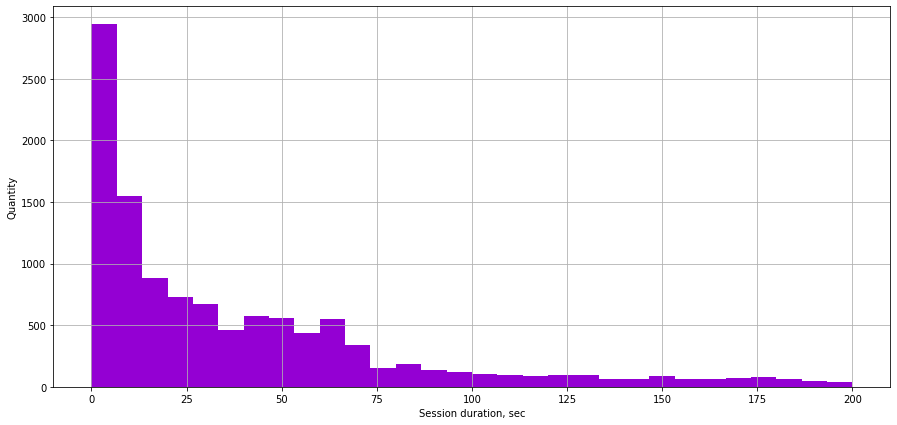

In [ ]:
plt.figure(figsize=(15, 7))
plt.xlabel('Session duration, sec')
plt.ylabel('Quantity')
train_data_10users.session_timespan.hist(bins=30, range=(0, 200), color='darkviolet')

**2. Bar charts of unique sites distribution for each user**

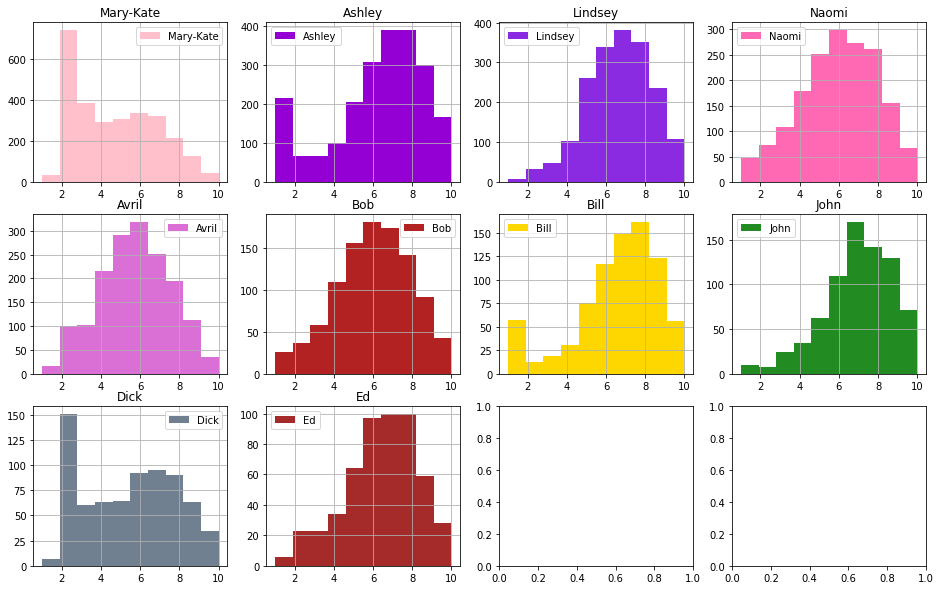

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for i, user in enumerate(color_dic):
    axes.flatten()[i].set_title('{}'.format(user))
    axes.flatten()[i].grid()
    axes.flatten()[i].hist(train_data_10users['#unique_sites'].loc[train_data_10users.target == '{}'.format(user)], color='{}'.format(color_dic[user]), label=user)
    axes.flatten()[i].legend()

**3. Bar chart of start hour distribution**

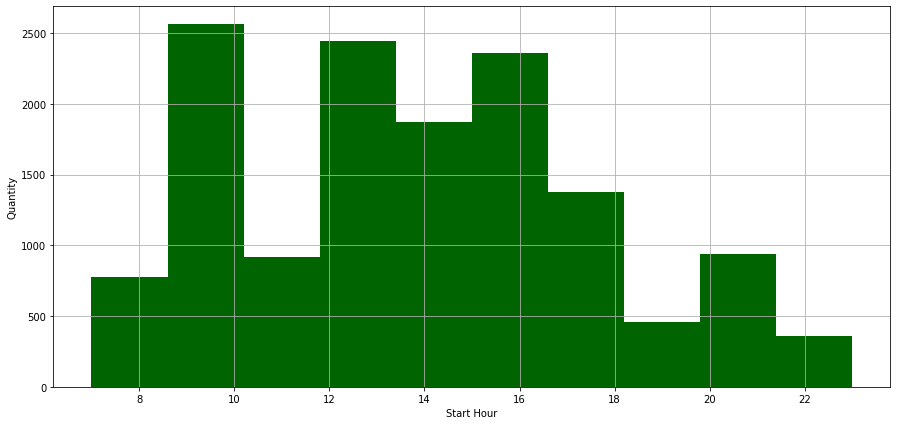

In [ ]:
plt.figure(figsize=(15, 7))
plt.xlabel('Start Hour')
plt.ylabel('Quantity')
train_data_10users['start_hour'].hist(color='darkgreen')

**4. Bar charts of start hour distribution for each user**

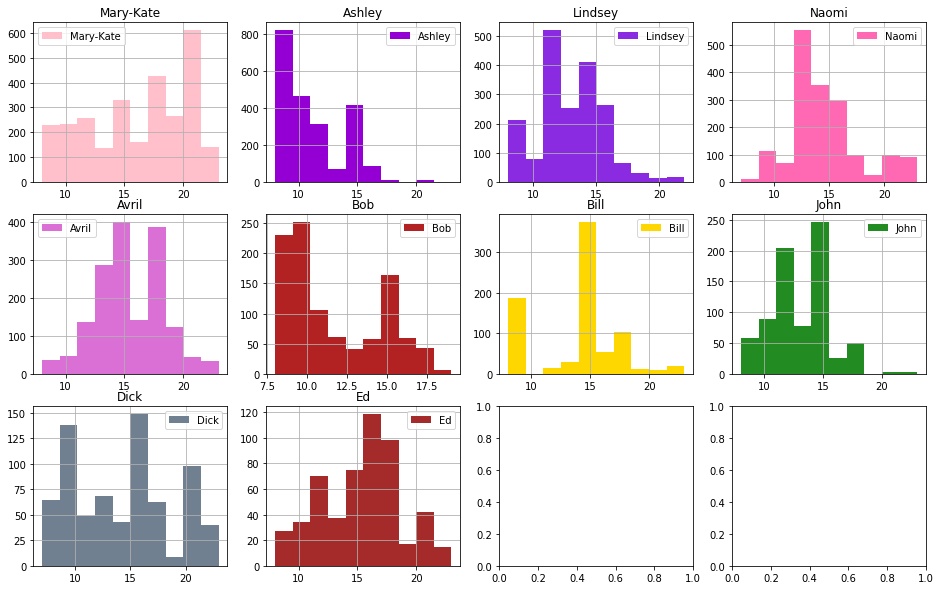

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for i, user in enumerate(color_dic):
    axes.flatten()[i].set_title('{}'.format(user))
    axes.flatten()[i].grid()
    axes.flatten()[i].hist(train_data_10users.start_hour.loc[train_data_10users.target == '{}'.format(user)], color='{}'.format(color_dic[user]), label=user)
    axes.flatten()[i].legend()

**5. Bar chart of day of week distribution**

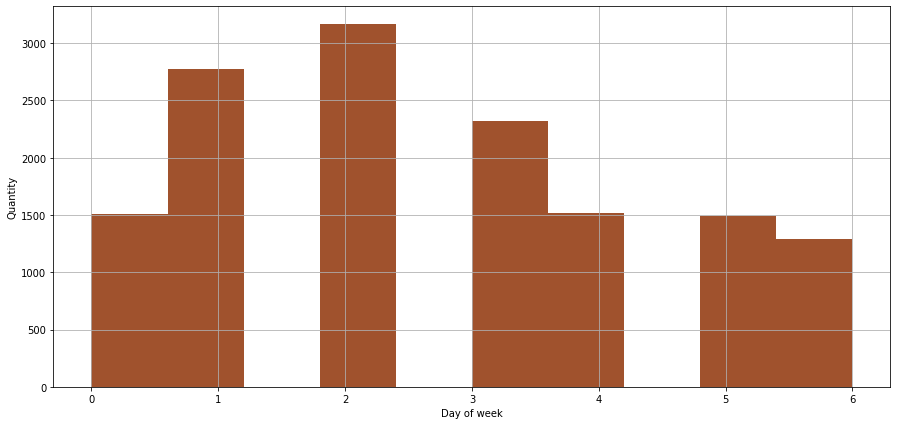

In [ ]:
plt.figure(figsize=(15, 7))
plt.xlabel('Day of week')
plt.ylabel('Quantity')
train_data_10users['day_of_week'].hist(color='sienna')

**6. Bar charts of day of week distribution or each user**

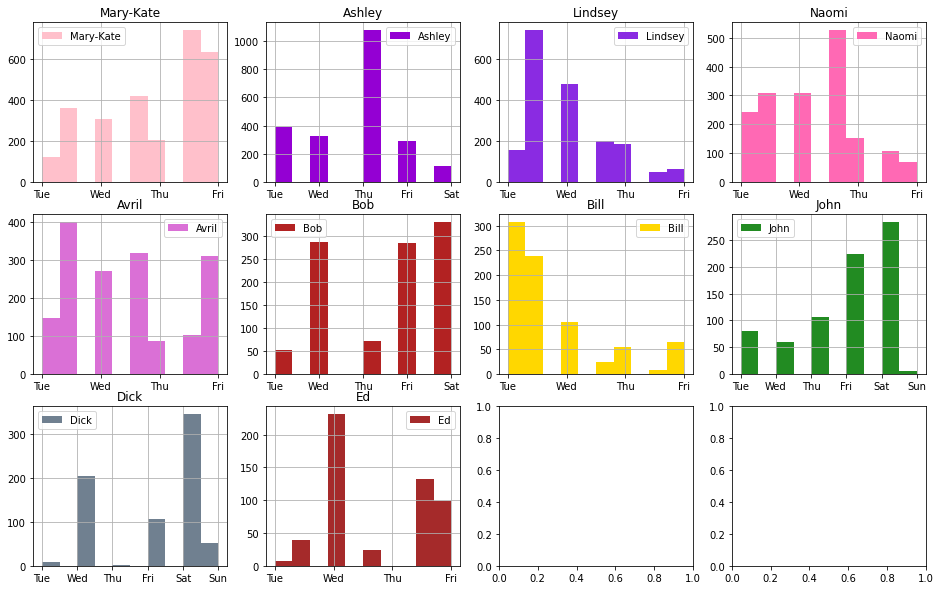

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for i, user in enumerate(color_dic):
    axes.flatten()[i].set_title('{}'.format(user))
    axes.flatten()[i].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    axes.flatten()[i].grid()
    axes.flatten()[i].hist(train_data_10users.day_of_week.loc[train_data_10users.target == '{}'.format(user)], color='{}'.format(color_dic[user]), label=user)
    axes.flatten()[i].legend()

**7. Lets plot seaborn barplot which shows visiting frequencies of the top 10 visited website**

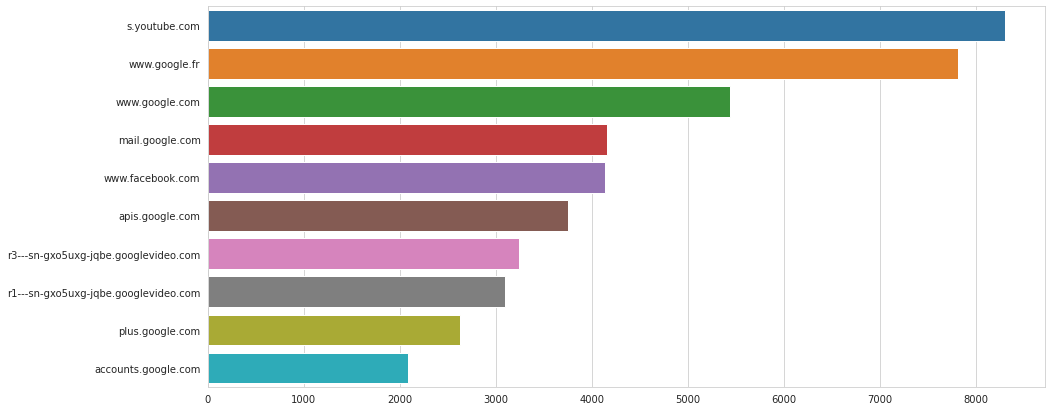

In [ ]:
top10_freqs = [x[1][1] for x in site_freqs[:10]]
top10_sites = [x[0] for x in site_freqs[:10]]

plt.figure(figsize=(15, 7))
sns.set_style('whitegrid')
sns.barplot(x=top10_freqs, y=top10_sites)

**Lets make some conclusions**

* Mary-Kate:
    * Most of the sessions are dominated by 2 unique sites
    * The beginning of the session falls on the evening
    * Most active on weekends
* Lindsey:
    * Goes to different sites, mostly 8 unique in the session
    * The beginning (most) of the session either at 11.00 or 14.00
    * Highest activity at the beginning of the week
* Ashley:
    * Many sessions with 8 unique sites, but there is also a tail when there are only 2 sites
    * In most cases, early morning
    * Mid-week activity
* John:
    * Peak at 7 unique sites
    * 15.00 or 12.00
    * Activity by the end of the working week is growing and is almost zero on weekends
* Ed:
    * Often 6, 7 or 8 unique sites
    * 16.00 highest activity with tails at 12.00 and 20.00
    * High activity on weekends
* Naomi:
    * Peak at 6 o'clock, close to normal
    * Highest lunchtime activity
    * Most in the middle of the week
* Bob:
    * Peak at 6, close to normal distribution.
    * Highest activity in the morning
    * Start and end of the work week, zero activity on weekends
* Bill:
    * Peak 8 sites with a tail in 1
    * Most active at 15.00 and in the morning
    * Beginning of the week
* Dick:
    * Often 2 unique sites
    * Activity in the middle of the day
    * Most on the weekend
* Avril:
    * Peak at 6, as close to normal as possible
    * Activity in the afternoon and towards the end of the working day
    * Approximately the same activity throughout the week

##**Part 7. Comparison of several algorithms in sessions from 10 sites**

In [ ]:
X_sparse_10users.shape

(14061, 4913)

**Splitting our sample for the two ones. One we`re gonna use for cross-validation second for evaluation**

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Auxiliary function to plot the learning lines**

In [54]:
def plot_validation_curves(param_values, grid_cv_results_):
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**Lets fit `KNeighborsClassifier` with 100 neighbors**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
train1 = round(cross_val_score(knn, X_train, y_train, cv=skf).mean(), 3)

knn.fit(X_train.todense(), y_train)
valid1 = round(accuracy_score(y_valid, knn.predict(X_valid), 3)

print('Train accuracy = {}; Test accuracy = {}'.format(train1, valid1))

Train accuracy = 0.563; Test accuracy = 0.584


**Lets fit `RandomForestClassifier` with 100 trees**

In [ ]:
forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)
train2 = round(cross_val_score(forest, X_train, y_train, cv=skf).mean(), 3)

forest.fit(X_train, y_train)
valid2 = round(accuracy_score(y_valid, forest.predict(X_valid)), 3)

print('Train accuracy = {}; Test accuracy = {}'.format(train2, valid2))

Train accuracy = 0.715; Test accuracy = 0.736


**Lets fit `LogisticRegression` with default parameter C**

In [ ]:
logit = LogisticRegression(random_state=17, n_jobs=-1)
train2_5 = round(cross_val_score(logit, X_train, y_train, cv=skf).mean(), 3)

logit.fit(X_train, y_train)
valid2_5 = round(accuracy_score(y_valid, logit.predict(X_valid)), 3)

print('Simple LOGISTIC Regression --> Train accuracy = {}; Test accuracy = {}'.format(train2_5, valid2_5))

Simple LOGISTIC Regression --> Train accuracy = 0.761; Test accuracy = 0.777


**Lets fit LogisticRegressionCV to understand the best C parameter**

In [ ]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.52 s, sys: 4.33 s, total: 7.85 s
Wall time: 30.4 s


**Mean accuracy scores for each C value**

In [ ]:
scores1 = logit_grid_searcher1.scores_.items()
scoress1 = np.zeros((1, 10))
for i in scores1:
    for j in i[1]:
        for k, l in enumerate(j):
            scoress1[0][k]+=l
logit_mean_cv_scores1 = scoress1/30
for i, el in enumerate(logit_mean_cv_scores1[0]):
    if el == logit_mean_cv_scores1.max():
        ind = i
    print('C = {}, mean score = {}'.format(round(logit_c_values1[i], 5), round(el, 3)))

C = 0.0001, mean score = 0.32
C = 0.00046, mean score = 0.473
C = 0.00215, mean score = 0.552
C = 0.01, mean score = 0.649
C = 0.04642, mean score = 0.714
C = 0.21544, mean score = 0.752
C = 1.0, mean score = 0.761
C = 4.64159, mean score = 0.758
C = 21.54435, mean score = 0.75
C = 100.0, mean score = 0.741


In [ ]:
print('The best result = {} for C = {}'.format(round(logit_mean_cv_scores1.max(), 6), logit_c_values1[ind]))

The best result = 0.761229 for C = 0.21544346900318823


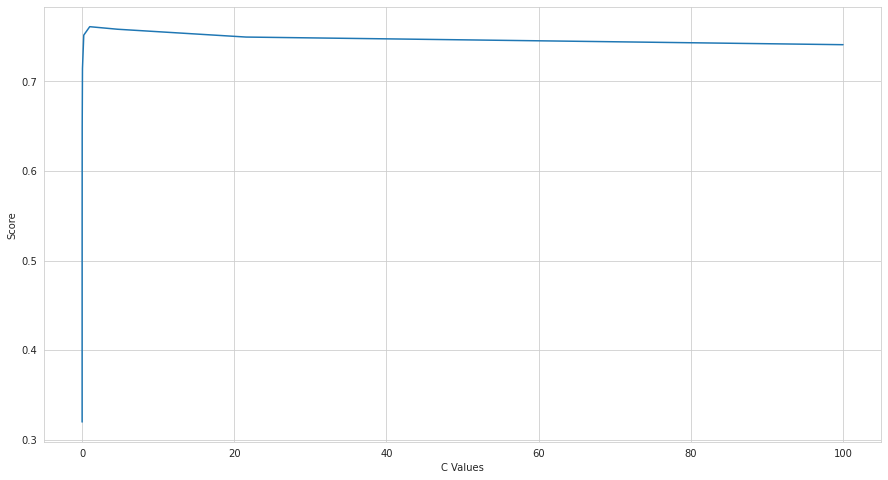

In [ ]:
plt.figure(figsize=(15,8))
plt.xlabel('C Values')
plt.ylabel('Score')
plt.plot(logit_c_values1, logit_mean_cv_scores1.reshape(-1 ,1));

**Lets fit another LogisticRegressionCV, but with C values in range `np.linspace`(0.1, 7, 20)

In [ ]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 3.34 s, sys: 3.71 s, total: 7.05 s
Wall time: 1min 15s


In [ ]:
scores2 = logit_grid_searcher2.scores_.items()
scoress2 = np.zeros((1, 20))
for i in scores2:
    for j in i[1]:
        for k, l in enumerate(j):
            scoress2[0][k]+=l
logit_mean_cv_scores2 = scoress2/30
for i, el in enumerate(logit_mean_cv_scores2[0]):
    if el == logit_mean_cv_scores2.max():
        ind = i
    print('C = {}, mean score = {}'.format(round(logit_c_values2[i], 5), round(el, 3)))

C = 0.1, mean score = 0.735
C = 0.46316, mean score = 0.759
C = 0.82632, mean score = 0.761
C = 1.18947, mean score = 0.761
C = 1.55263, mean score = 0.761
C = 1.91579, mean score = 0.761
C = 2.27895, mean score = 0.76
C = 2.64211, mean score = 0.759
C = 3.00526, mean score = 0.76
C = 3.36842, mean score = 0.759
C = 3.73158, mean score = 0.759
C = 4.09474, mean score = 0.758
C = 4.45789, mean score = 0.758
C = 4.82105, mean score = 0.757
C = 5.18421, mean score = 0.757
C = 5.54737, mean score = 0.756
C = 5.91053, mean score = 0.756
C = 6.27368, mean score = 0.755
C = 6.63684, mean score = 0.754
C = 7.0, mean score = 0.753


In [ ]:
print('The best result = {} for C = {}'.format(round(logit_mean_cv_scores2.max(), 6), round(logit_c_values2[ind], 3)))

The best result = 0.761229 for C = 1.916


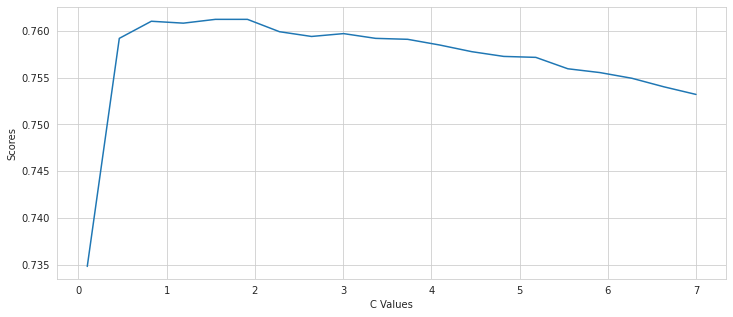

In [ ]:
plt.figure(figsize=(12, 5))
plt.xlabel('C Values')
plt.ylabel('Scores')
plt.plot(logit_c_values2, logit_mean_cv_scores2.reshape(-1, 1));

**Lets fir Linear SVC**

In [ ]:
svm = LinearSVC(C=1, random_state=17)
train3 = (cross_val_score(svm, X_train, y_train, cv=skf).mean())

svm.fit(X_train, y_train)
valid3 = accuracy_score(y_valid, svm.predict(X_valid))

print('Linear SVC --> train score = {}, test score = {}'.format(round(train3, 3), round(valid3, 3)))

Linear SVC --> train score = 0.751, test score = 0.777


**Lets try to find the best C parameter for Linear SVC**

In [ ]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 1min 57s, sys: 110 ms, total: 1min 57s
Wall time: 1min 56s


In [ ]:
print('Best score = {}, with C = {}'.format(svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_))

Best score = 0.7001622196897438, with C = {'C': 2222.2223000000004}


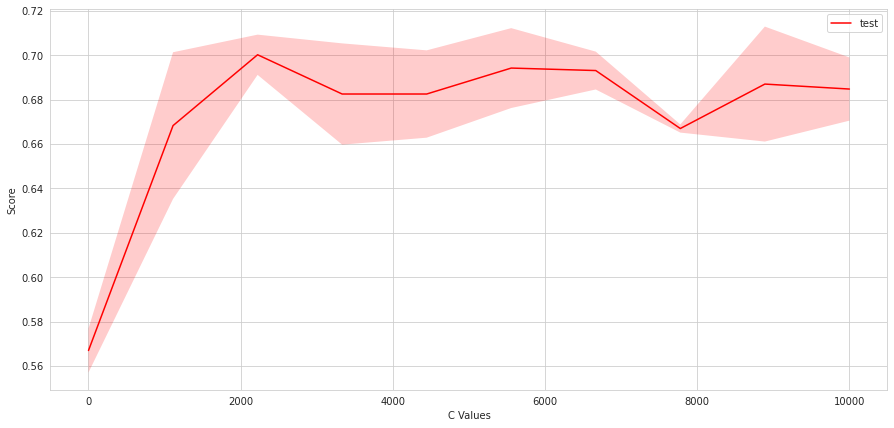

In [ ]:
plt.figure(figsize=(15, 7))
plt.xlabel('C Values')
plt.ylabel('Score')
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Lets try to change the range for C values**

In [ ]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 3min 16s, sys: 190 ms, total: 3min 16s
Wall time: 3min 16s


In [ ]:
print('Best score = {}, with C = {}'.format(svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_))

Best score = 0.7701686093803548, with C = {'C': 0.10434482758620689}


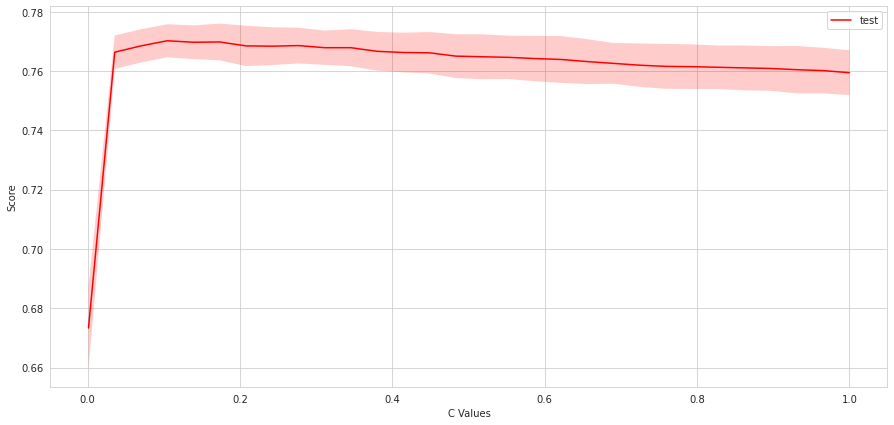

In [ ]:
plt.figure(figsize=(15, 7))
plt.xlabel('C Values')
plt.ylabel('Score')
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

**Lets try to apply our best estimator on the different configures of session length and window size**

In [ ]:
def model_assessment(estimator, path_to_X_sparse, path_to_y, cv, random_state=17, test_size=0.3):
    
    X_sparse = scipy.sparse.load_npz(os.path.join(PATH_TO_DATA, path_to_X_sparse))
    with open(os.path.join(PATH_TO_DATA, path_to_y), 'r') as filet:
        y = filet.readlines()

    
    X_train_f, X_valid_f, y_train_f, y_valid_f = train_test_split(X_sparse, y, 
                                                      test_size=test_size, 
                                                     random_state=17, stratify=y)
    mean_score = cross_val_score(estimator, X_train_f, y_train_f, cv=cv).mean()
    estimator.fit(X_train_f, y_train_f)
    valid_score = accuracy_score(estimator.predict(X_valid_f), y_valid_f)
    return mean_score, valid_score

**Lets check if it works**

In [ ]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'Pickles/X_sparse_10users.npz'),
        os.path.join(PATH_TO_DATA, 'Pickles/y_10users.txt'), skf, random_state=17, test_size=0.3)

(0.7651891402333714, 0.7793315951647309)

**So now lets try to apply this function to a different configurations**

In [ ]:

estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = 'Pickles/X_sparse_{0}users_s{1}_w{2}.npz'.format(10, session_length, window_size)
        path_to_y_pkl = 'Pickles/y_{0}users_s{1}_w{2}.txt'.format(10, session_length, window_size)
        start = time.time()
        cvc, vc = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf)
        end = time.time() - start
        print('Session length = {}, Window size = {}, Train score = {}, Test score = {}, Time = {} sec'.format(session_length,
                                                                                                               window_size, round(cvc, 3), round(vc, 3), round(end, 5)))

Session length = 15, Window size = 10, Train score = 0.823, Test score = 0.837, Time = 3.69531 sec
Session length = 10, Window size = 10, Train score = 0.765, Test score = 0.779, Time = 2.24886 sec
Session length = 15, Window size = 7, Train score = 0.845, Test score = 0.861, Time = 5.36206 sec
Session length = 10, Window size = 7, Train score = 0.798, Test score = 0.81, Time = 2.98023 sec
Session length = 7, Window size = 7, Train score = 0.747, Test score = 0.76, Time = 1.88461 sec
Session length = 15, Window size = 5, Train score = 0.866, Test score = 0.873, Time = 7.23738 sec
Session length = 10, Window size = 5, Train score = 0.819, Test score = 0.822, Time = 4.27214 sec
Session length = 7, Window size = 5, Train score = 0.775, Test score = 0.782, Time = 2.74238 sec
Session length = 5, Window size = 5, Train score = 0.726, Test score = 0.732, Time = 1.84333 sec


**As we can see the best result shows sample with session length 15 and window size 5**

##**Part 8. Kaggle Competition "Catch me if you can"**

**Lets download the data from competition**

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [ ]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


**Lets concatenate our train and test samples to make sparse matrix for a whole sample**

In [4]:
train_test_df = pd.concat([train_df, test_df])

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: float64

In [ ]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   site1   82797 non-null  int64  
 1   time1   82797 non-null  object 
 2   site2   81308 non-null  float64
 3   time2   81308 non-null  object 
 4   site3   80075 non-null  float64
 5   time3   80075 non-null  object 
 6   site4   79182 non-null  float64
 7   time4   79182 non-null  object 
 8   site5   78341 non-null  float64
 9   time5   78341 non-null  object 
 10  site6   77566 non-null  float64
 11  time6   77566 non-null  object 
 12  site7   76840 non-null  float64
 13  time7   76840 non-null  object 
 14  site8   76151 non-null  float64
 15  time8   76151 non-null  object 
 16  site9   75484 non-null  float64
 17  time9   75484 non-null  object 
 18  site10  74806 non-null  float64
 19  time10  74806 non-null  object 
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


**In our sample we have 2297 sessions of hour user Alice and 251264 sessions of other users**

In [5]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**The sites started indexing from 1, so lets change all the Nulls for 0**

In [6]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [7]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


**Now let create sparse matrix and then divide it to original shape for training and test, also lets divide trainig sample to training one and to valid one**

In [10]:
train_test_sparse = csr_matrix((csr_prepare(train_test_df_sites.values)))[:, 1:]
X_train_sparse = train_test_sparse[:-test_df.shape[0], :]
X_test_sparse = train_test_sparse[train_df.shape[0]:, :]
y = train_df.iloc[:,-1]

**Lets see on dimensions of our matrixes**

In [ ]:
print('Train {}, {}\nTest {}, {}'.format(X_train_sparse.shape[0], X_train_sparse.shape[1], 
                                       X_test_sparse.shape[0], X_test_sparse.shape[1]))

Train 253561, 48371
Test 82797, 48371


In [11]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

**So now we are going to create SGDClassifier with a logistic loss function and the other default parameters**

In [ ]:
sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)
print('RocAuc score: {}'.format(round(roc_auc_score(y_valid, logit_valid_pred_proba[:,1]), 3)))

RocAuc score: 0.934


**Lets try to fit the SGDClassifier with default parameters on the whole trainig sample and send the predictions to Kaggle**

In [ ]:
%%time
sgd_logit.fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)

CPU times: user 671 ms, sys: 109 ms, total: 780 ms
Wall time: 663 ms


In [63]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
write_to_submission_file(logit_test_pred_proba[:,1], 'prediction.csv')

**So the result on leaderboard is 0.91486. This is the baseline which we are going to improve**

**Lets try to improve our results with adding some additional features**

In [ ]:
def new_featuress(data):
    n_features = pd.DataFrame()

    times = data[['time%s' % i for i in range(1, 11)]]
    sites = data[['site%s' % i for i in range(1, 11)]].fillna(0).astype(int).values

    for i in range(1, 10):
        n_features['T_diff{}'.format(i)] = (pd.to_datetime(times['time{}'.format(i+1)]) - pd.to_datetime(times['time{}'.format(i)])).dt.total_seconds().fillna(0)
    
    n_features['session_timespan'] = np.sum(n_features, axis=1)
    n_features['start_hour'] = pd.to_datetime(times['time1']).dt.hour
    n_features['weekday'] = pd.to_datetime(times['time1']).dt.weekday
    n_features['unique_sites'] = [len(np.unique(session[session != 0])) for session in sites]

    return n_features    

In [ ]:
train_test_new = new_featuress(train_df)

In [ ]:
train_test_new.head()

,T_diff1,T_diff2,T_diff3,T_diff4,T_diff5,T_diff6,T_diff7,T_diff8,T_diff9,session_timespan,start_hour,weekday,unique_sites
session_id,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,3,1
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,26.0,11,5,7
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0,16,0,4
4,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,270.0,10,4,1
5,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,246.0,10,4,4


**Dividing our features on numerical and categorical ones**

In [ ]:
train_test_new_numeric = train_test_new.loc[:, :'session_timespan']
train_test_new_cat = train_test_new.loc[:, 'start_hour':]

In [ ]:
#Scaling our numerical data
scaler = StandardScaler()
numerical = train_test_new_numeric.columns
train_test_new_numeric[numerical] = scaler.fit_transform(train_test_new_numeric[numerical])
train_test_new_numeric.head()

,T_diff1,T_diff2,T_diff3,T_diff4,T_diff5,T_diff6,T_diff7,T_diff8,T_diff9,session_timespan
session_id,,,,,,,,,,
1,-0.191229,-0.180434,-0.186631,-0.193139,-0.192809,-0.193165,-0.192025,-0.190596,-0.190791,-0.468233
2,-0.191229,-0.170968,-0.186631,-0.193139,-0.192809,-0.179357,-0.192025,0.140975,-0.175945,-0.380330
3,-0.181131,-0.170968,-0.186631,-0.193139,-0.192809,-0.179357,-0.177680,-0.176180,-0.161099,-0.444566
4,0.111727,0.103540,0.137505,0.189184,0.202862,0.221062,0.238309,0.241888,0.254585,0.444604
5,1.192272,-0.180434,-0.175826,-0.193139,0.281996,-0.193165,-0.192025,0.775285,-0.116561,0.363463


In [ ]:
#Transforming our categorical data
train_test_cat_dummies = pd.get_dummies(train_test_new_cat, columns=train_test_new_cat.columns, drop_first=True)
train_test_cat_dummies.head()

,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,unique_sites_2,unique_sites_3,unique_sites_4,unique_sites_5,unique_sites_6,unique_sites_7,unique_sites_8,unique_sites_9,unique_sites_10
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
#Concatting those two samples
train_test_new_fe = pd.concat([train_test_new_numeric, train_test_cat_dummies], axis=1)
train_test_new_fe.head()

,T_diff1,T_diff2,T_diff3,T_diff4,T_diff5,T_diff6,T_diff7,T_diff8,T_diff9,session_timespan,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,unique_sites_2,unique_sites_3,unique_sites_4,unique_sites_5,unique_sites_6,unique_sites_7,unique_sites_8,unique_sites_9,unique_sites_10
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.191229,-0.180434,-0.186631,-0.193139,-0.192809,-0.193165,-0.192025,-0.190596,-0.190791,-0.468233,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.191229,-0.170968,-0.186631,-0.193139,-0.192809,-0.179357,-0.192025,0.140975,-0.175945,-0.380330,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,-0.181131,-0.170968,-0.186631,-0.193139,-0.192809,-0.179357,-0.177680,-0.176180,-0.161099,-0.444566,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0.111727,0.103540,0.137505,0.189184,0.202862,0.221062,0.238309,0.241888,0.254585,0.444604,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,1.192272,-0.180434,-0.175826,-0.193139,0.281996,-0.193165,-0.192025,0.775285,-0.116561,0.363463,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
train_test_new_fe.shape

(253561, 41)

In [ ]:
train_test_new_sparse = csr_matrix(train_test_new_fe)
train_test_new_sparse.shape

(253561, 41)

In [ ]:
#Dividing our sample to train and valid one
train_share = int(.7 * X_train_sparse.shape[0])
X_train_new_fe, X_valid_new_fe = train_test_new_sparse[:train_share, :], train_test_new_sparse[train_share:, :]

X_train_new = hstack([X_train, X_train_new_fe])
X_valid_new = hstack([X_valid, X_valid_new_fe])
X_final = hstack([X_train_sparse, train_test_new_sparse])

In [ ]:
#Lets do it the same actions to the test sample
test_new_fe = new_featuress(test_df)

In [ ]:
test_new_fe.head()

,T_diff1,T_diff2,T_diff3,T_diff4,T_diff5,T_diff6,T_diff7,T_diff8,T_diff9,session_timespan,start_hour,weekday,unique_sites
session_id,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,7.0,11,5,10
2,25.0,5.0,8.0,3.0,1.0,13.0,6.0,1.0,23.0,85.0,11,3,1
3,1.0,1.0,61.0,1.0,1.0,1.0,1.0,14.0,3.0,84.0,15,4,2
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,10,1,7
5,1.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,4.0,13.0,15,4,8


In [ ]:
#Dividing our samples to numerical and categorical
test_new_numeric = test_new_fe.loc[:, :'session_timespan']
test_new_cat = test_new_fe.loc[:, 'start_hour':]

In [ ]:
#Transforming our data
test_new_cat_dummies = pd.get_dummies(test_new_cat, columns=test_new_cat.columns, drop_first=True)
test_new_numeric[numerical] = scaler.fit_transform(test_new_numeric[numerical])

In [ ]:
test_new_numeric.head()

,T_diff1,T_diff2,T_diff3,T_diff4,T_diff5,T_diff6,T_diff7,T_diff8,T_diff9,session_timespan
session_id,,,,,,,,,,
1,-0.190652,-0.171221,-0.184455,-0.188461,-0.194178,-0.192588,-0.188929,-0.099088,-0.189982,-0.445546
2,0.064324,-0.132001,-0.092022,-0.151075,-0.180384,-0.003503,-0.103841,-0.173908,0.158300,-0.172012
3,-0.180453,-0.171221,0.520346,-0.175999,-0.180384,-0.178043,-0.174748,0.020623,-0.144554,-0.175519
4,-0.190652,-0.171221,-0.172901,-0.188461,-0.180384,-0.192588,-0.188929,-0.173908,-0.189982,-0.456067
5,-0.180453,-0.171221,-0.115130,-0.175999,-0.194178,-0.192588,-0.188929,-0.188872,-0.129411,-0.424505


In [ ]:
test_new_cat_dummies.head()

,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,unique_sites_2,unique_sites_3,unique_sites_4,unique_sites_5,unique_sites_6,unique_sites_7,unique_sites_8,unique_sites_9,unique_sites_10
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
#Concating our new transformed data
test_new_all = pd.concat([test_new_numeric, test_new_cat_dummies], axis=1)

In [ ]:
#Making it sparse
test_new_all_sparse = csr_matrix(test_new_all)
test_new_all_sparse.shape

(82797, 41)

In [ ]:
X_test_new = hstack([X_test_sparse, test_new_all_sparse])

In [ ]:
%%time 
sgd_new = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
skf_new = StratifiedKFold(n_splits=8, shuffle=True, random_state=17)
params = {
    'alpha': np.linspace(0.000001, 0.0002, 100)
}
grid_s = GridSearchCV(sgd_new, param_grid=params, scoring='roc_auc', n_jobs=-1)
grid_s.fit(X_train_new, y_train)

CPU times: user 5.42 s, sys: 1.21 s, total: 6.64 s
Wall time: 2min 55s


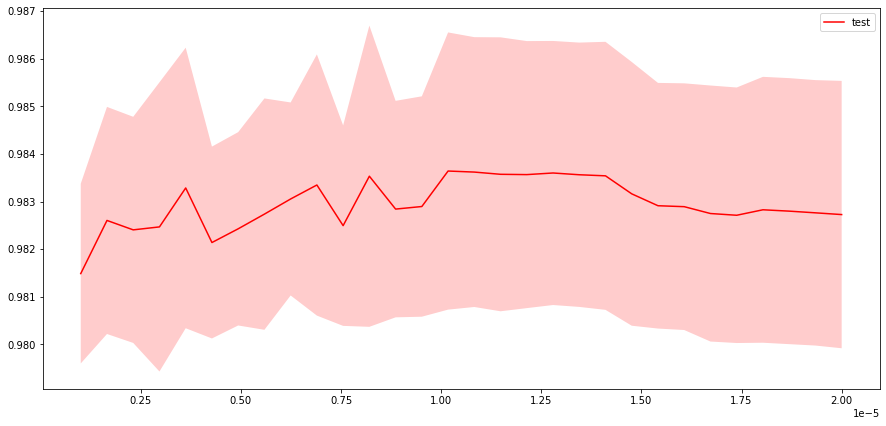

In [ ]:
plt.figure(figsize=(15,7))
plot_validation_curves(params['alpha'], grid_s.cv_results_)

In [ ]:
#Lets try to see what it shows on validation sample
grid_s.best_estimator_.fit(X_train_new, y_train)
predict_proba_new = grid_s.best_estimator_.predict_proba(X_valid_new)
print('RocAuc score for valid = {}'.format(round(roc_auc_score(y_valid, predict_proba_new[:, 1]), 10)))

RocAuc score for valid = 0.9820591614


In [ ]:
#Lets see the best parameter
grid_s.best_params_['alpha']

1.105050505050505e-05

In [ ]:
sgd_final = SGDClassifier(loss='log', alpha=grid_s.best_params_['alpha'], random_state=17, n_jobs=-1)
sgd_final.fit(X_final, y)
new_results = sgd_final.predict_proba(X_test_new)
write_to_submission_file(new_results[:,1], 'predictions_new.csv')

**The result for this SGDClassifier is 0.94483**

##**Part 9. Vowpal Wabbit**

In [ ]:
!apt-get install libboost-program-options-dev zlib1g-dev libboost-python-dev vowpal-wabbit

!pip install vowpalwabbit

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-program-options-dev is already the newest version (1.65.1.0ubuntu1).
libboost-program-options-dev set to manually installed.
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libboost-python-dev is already the newest version (1.65.1.0ubuntu1).
libboost-python-dev set to manually installed.
The following additional packages will be installed:
  libvw0
Suggested packages:
  vowpal-wabbit-doc
The following NEW packages will be installed:
  libvw0 vowpal-wabbit
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 797 kB of archives.
After this operation, 3,034 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libvw0 amd64 8.5.0.dfsg1-1 [748 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 vowpal-wabbit amd64 8.5.0.dfsg1-1 [49.1 kB]
Fetched 79

**Lets write a function which will tranform all our data to vw format**

In [ ]:
def arrays_to_vw(X, y=None, train=True, out_file='tmp.vw'):
    out_data = []
    output_f = open(os.path.join(PATH_TO_DATA, '{}'.format(out_file)), 'w')
    if train:
        for i, j in enumerate(X[sites].fillna(0).astype('int').values):
            element = ''
            for el in j:
                element = element + str(el) + ' '
            out_data_el = str(y[i]) + ' | ' + element[:-1]
            #out_data = np.append(out_data, out_data_el)
            if i%20000 == 0:
                print('Checkpoint {}/{}'.format(i, X.shape[0]))
            output_f.write(out_data_el+'\n')
    else:
        for i, j in enumerate(X[sites].fillna(0).astype('int').values):
            element = ''
            for el in j:
                element = element + str(el) + ' '
            out_data_el = str(0) + ' | ' + element[:-1]
            #out_data = np.append(out_data, out_data_el)
            if i%40000 == 0:
                print('Checkpoint {}/{}'.format(i, X.shape[0]))
            output_f.write(out_data_el+'\n')
    output_f.close()
    pass

**Lets apply this function to our sample from competition**

In [22]:
sites = ['site' + str(i) for i in range(1, 11)]
y_for_vw = y.values

In [ ]:
%%time
arrays_to_vw(train_df, y_for_vw, out_file='train.vw')
arrays_to_vw(test_df, train=False, out_file='test.vw')

Checkpoint 0/253561
Checkpoint 20000/253561
Checkpoint 40000/253561
Checkpoint 60000/253561
Checkpoint 80000/253561
Checkpoint 100000/253561
Checkpoint 120000/253561
Checkpoint 140000/253561
Checkpoint 160000/253561
Checkpoint 180000/253561
Checkpoint 200000/253561
Checkpoint 220000/253561
Checkpoint 240000/253561
Checkpoint 0/82797
Checkpoint 40000/82797
Checkpoint 80000/82797
CPU times: user 3.8 s, sys: 21.7 ms, total: 3.82 s
Wall time: 3.91 s


In [ ]:
!head -5 $PATH_TO_DATA/train.vw

0 | 718 0 0 0 0 0 0 0 0 0
0 | 890 941 3847 941 942 3846 3847 3846 1516 1518
0 | 14769 39 14768 14769 37 39 14768 14768 14768 14768
0 | 782 782 782 782 782 782 782 782 782 782
0 | 22 177 175 178 177 178 175 177 177 178


In [ ]:
!head -5 $PATH_TO_DATA/test.vw

0 | 29 35 22 321 23 2211 6730 21 44582 15336
0 | 782 782 782 782 782 782 782 782 782 782
0 | 55 55 55 55 55 55 55 55 1445 1445
0 | 1023 1022 50 222 202 3374 50 48 48 3374
0 | 301 301 301 66 67 69 70 68 71 167


In [ ]:
#Lets store all pathes in variables
train_vw = os.path.join(PATH_TO_DATA, 'train.vw')
test_vw = os.path.join(PATH_TO_DATA, 'test.vw')
model = os.path.join(PATH_TO_DATA, 'vw_model.vw')
pred = os.path.join(PATH_TO_DATA, 'vw_pred.csv')

In [ ]:
#Fitting vowpal wabbit on the whole training sample
%%time
!vw --binary $train_vw --passes 3 -c --random_seed 17 -f $model

final_regressor = /content/drive/MyDrive/Colab_Notebooks/User_Identify/Data_Files/vw_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
using cache_file = /content/drive/MyDrive/Colab_Notebooks/User_Identify/Data_Files/train.vw.cache
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  -1.0000  -1.0000       11
0.000000 0.000000            2            2.0  -1.0000  -1.0000       11
0.000000 0.000000            4            4.0  -1.0000  -1.0000       11
0.000000 0.000000            8            8.0  -1.0000  -1.0000       11
0.000000 0.000000           16           16.0  -1.0000  -1.0000       11
0.000000 0.000000           32           32.0  -1.0000  -1.0000       11
0.000000 0.000000           64           64.0  -1.0000  -1.0000       1

In [ ]:
!vw -t -i $model -d $test_vw -p $pred

only testing
predictions = /content/drive/MyDrive/Colab_Notebooks/User_Identify/Data_Files/vw_pred.csv
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /content/drive/MyDrive/Colab_Notebooks/User_Identify/Data_Files/test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   0.0000  -1.0000       11
1.000000 1.000000            2            2.0   0.0000  -1.0000       11
1.000000 1.000000            4            4.0   0.0000  -1.0000       11
0.948205 0.896409            8            8.0   0.0000  -1.0000       11
0.894980 0.841756           16           16.0   0.0000  -1.0000       11
0.917017 0.939053           32           32.0   0.0000  -0.9079       11
0.942500 0.967983           64           64.0   0.0000  -1.0000       11
0.956816 0.971132          128          128.0   0

In [ ]:
predicted_vw = pd.read_csv(pred, header=None)

In [ ]:
write_to_submission_file(predicted_vw.values, 'predictions_vw.csv')

**Kaggle shows 0.83735. So Vowpal Wabbit is not the best solution for this task:)**

##**Part 10. Final attempt**

**Lets try to have a deeper look on our training sample and figure some Alice`s patterns**

In [12]:
def new_featuress1(data):
    n_features = pd.DataFrame()

    times = data[['time%s' % i for i in range(1, 11)]]
    sites = data[['site%s' % i for i in range(1, 11)]].fillna(0).astype(int).values

    for i in range(1, 10):
        n_features['T_diff{}'.format(i)] = (pd.to_datetime(times['time{}'.format(i+1)]) - pd.to_datetime(times['time{}'.format(i)])).dt.total_seconds().fillna(0)
    
    n_features['session_timespan'] = np.sum(n_features, axis=1)
    n_features['start_hour'] = pd.to_datetime(times['time1']).dt.hour
    n_features['weekday'] = pd.to_datetime(times['time1']).dt.weekday
    n_features['unique_sites'] = [len(np.unique(session[session != 0])) for session in sites]

    return n_features

In [13]:
final_train = new_featuress1(train_df)
final_train['target'] = y

In [14]:
final_train.head()

,T_diff1,T_diff2,T_diff3,T_diff4,T_diff5,T_diff6,T_diff7,T_diff8,T_diff9,session_timespan,start_hour,weekday,unique_sites,target
session_id,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,3,1,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,26.0,11,5,7,0
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0,16,0,4,0
4,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,270.0,10,4,1,0
5,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,246.0,10,4,4,0


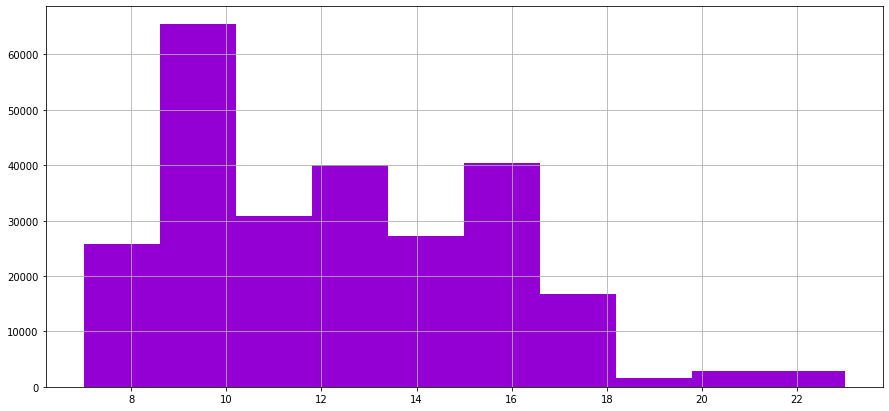

In [15]:
plt.figure(figsize=(15, 7))
final_train['start_hour'].hist(color='darkviolet')

In [16]:
id_name_dict = {1: 'Alice', 0: 'Other'}
final_train['target'] = final_train['target'].map(id_name_dict)

color_dic = {'Alice':'red', 'Other':'black'}

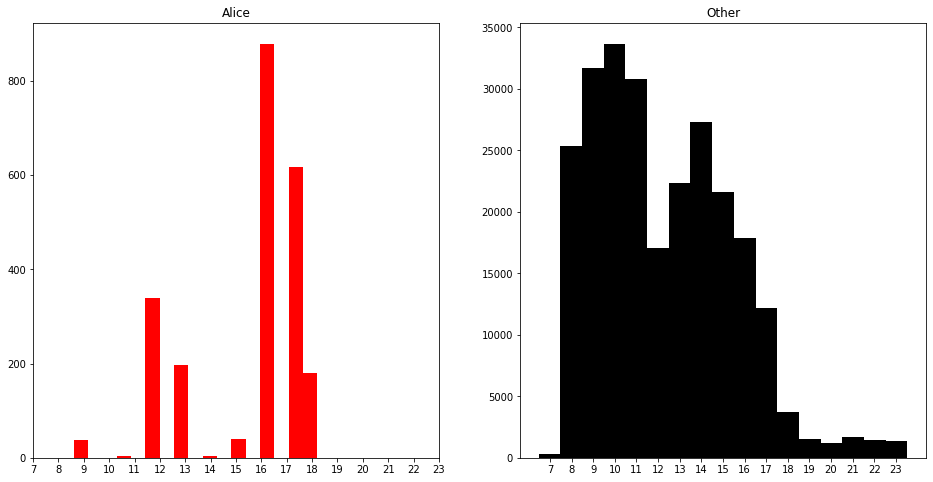

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
for i, user in enumerate(color_dic):
    axes[i].set_title('{}'.format(user))
    axes[i].hist(final_train['start_hour'].loc[final_train.target == '{}'.format(user)], color='{}'.format(color_dic['{}'.format(user)]), bins=17)
    axes[i].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
    axes[i].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])

In [18]:
final_train.start_hour.loc[final_train.target == 'Alice'].value_counts()

16    879
17    618
12    340
13    196
18    179
15     40
9      38
14      4
11      3
Name: start_hour, dtype: int64

In [19]:
#Lets create new feature if session start hour is in Alice`s interval, also we can exclude 11 and 14 as there are only couple of sessions with it
alice_int = [9, 12, 13, 15, 16, 17, 18]
final_train['is_alice_hours'] = [1 if x in alice_int else 0 for x in final_train.start_hour.values]

In [20]:
final_train.head()

,T_diff1,T_diff2,T_diff3,T_diff4,T_diff5,T_diff6,T_diff7,T_diff8,T_diff9,session_timespan,start_hour,weekday,unique_sites,target,is_alice_hours
session_id,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,3,1,Other,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,26.0,11,5,7,Other,0
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0,16,0,4,Other,1
4,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,270.0,10,4,1,Other,0
5,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,246.0,10,4,4,Other,0


In [23]:
train_sites = train_df[sites].fillna(0).astype('int')
train_sites['target'] = y

In [24]:
alice_sites = []
for i in range(1, 11):
    alice_sites = np.append(alice_sites, train_sites['site{}'.format(i)].loc[train_sites.target == 1].values)
alice_sites = np.unique(alice_sites)

In [25]:
#New feature which shows does include session at least one site from all the Alice`s sites
final_train['is_alice_sites'] = [0 if len(set(alice_sites) & set(train_sites.iloc[x, 0:9].values)) == 0 else 1 for x in range(final_train.shape[0])]

In [26]:
final_train.drop(columns='target', inplace=True)

In [27]:
final_train.head()

,T_diff1,T_diff2,T_diff3,T_diff4,T_diff5,T_diff6,T_diff7,T_diff8,T_diff9,session_timespan,start_hour,weekday,unique_sites,is_alice_hours,is_alice_sites
session_id,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,3,1,0,1
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,26.0,11,5,7,0,1
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0,16,0,4,1,1
4,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,270.0,10,4,1,0,0
5,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,246.0,10,4,4,0,1


**Lets prepare this samples to a sparse format to be able to fit and make predictions**

In [28]:
final_train_num = final_train.loc[:, :'session_timespan']
final_train_cat = final_train.loc[:, 'start_hour':'weekday']
final_train_other = final_train[['is_alice_hours', 'is_alice_sites']]

In [29]:
scaler = StandardScaler()
numerical = final_train_num.columns
final_train_num[numerical] = scaler.fit_transform(final_train_num[numerical])
final_train_cat = pd.get_dummies(final_train_cat, columns=final_train_cat.columns, drop_first=True)

In [30]:
final_train_cat.head()

,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
session_id,,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [31]:
final_train_fe = pd.concat([final_train_num, final_train_cat, final_train_other], axis=1)

In [32]:
final_train_fe.head()

,T_diff1,T_diff2,T_diff3,T_diff4,T_diff5,T_diff6,T_diff7,T_diff8,T_diff9,session_timespan,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,is_alice_hours,is_alice_sites
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.191229,-0.180434,-0.186631,-0.193139,-0.192809,-0.193165,-0.192025,-0.190596,-0.190791,-0.468233,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,-0.191229,-0.170968,-0.186631,-0.193139,-0.192809,-0.179357,-0.192025,0.140975,-0.175945,-0.380330,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,-0.181131,-0.170968,-0.186631,-0.193139,-0.192809,-0.179357,-0.177680,-0.176180,-0.161099,-0.444566,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0.111727,0.103540,0.137505,0.189184,0.202862,0.221062,0.238309,0.241888,0.254585,0.444604,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,1.192272,-0.180434,-0.175826,-0.193139,0.281996,-0.193165,-0.192025,0.775285,-0.116561,0.363463,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [33]:
final_train_fe_sparse = csr_matrix(final_train_fe)

In [34]:
train_share = int(.7 * final_train_fe_sparse.shape[0])
final_train_new_fe, final_valid_new_fe = final_train_fe_sparse[:train_share, :], final_train_fe_sparse[train_share:, :]

final_train_new = hstack([X_train, final_train_new_fe])
final_valid_new = hstack([X_valid, final_valid_new_fe])
final_train_X = hstack([X_train_sparse, final_train_fe_sparse])

In [35]:
final_train_X.shape

(253561, 48405)

In [36]:
final_test = new_featuress1(test_df)
test_sites = test_df[sites].fillna(0).astype('int')

In [37]:
final_test['is_alice_hours'] = [1 if x in alice_int else 0 for x in final_test.start_hour.values]
final_test['is_alice_sites'] = [0 if len(set(alice_sites) & set(test_sites.iloc[x, 0:9].values)) == 0 else 1 for x in range(final_test.shape[0])]

In [38]:
final_test.head()

,T_diff1,T_diff2,T_diff3,T_diff4,T_diff5,T_diff6,T_diff7,T_diff8,T_diff9,session_timespan,start_hour,weekday,unique_sites,is_alice_hours,is_alice_sites
session_id,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,7.0,11,5,10,0,1
2,25.0,5.0,8.0,3.0,1.0,13.0,6.0,1.0,23.0,85.0,11,3,1,0,0
3,1.0,1.0,61.0,1.0,1.0,1.0,1.0,14.0,3.0,84.0,15,4,2,1,0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,10,1,7,0,0
5,1.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,4.0,13.0,15,4,8,1,1


In [39]:
final_test_num = final_test.loc[:, :'session_timespan']
final_test_cat = final_test.loc[:, 'start_hour':'weekday']
final_test_other = final_test[['is_alice_hours', 'is_alice_sites']]

In [40]:
final_test_num[numerical] = scaler.fit_transform(final_test_num[numerical])
final_test_cat = pd.get_dummies(final_test_cat, columns=final_test_cat.columns, drop_first=True)

In [42]:
final_test_fe = pd.concat([final_test_num, final_test_cat, final_test_other], axis=1)
final_test_fe_sparse = csr_matrix(final_test_fe)

In [43]:
final_test_fe.head()

,T_diff1,T_diff2,T_diff3,T_diff4,T_diff5,T_diff6,T_diff7,T_diff8,T_diff9,session_timespan,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,is_alice_hours,is_alice_sites
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.190652,-0.171221,-0.184455,-0.188461,-0.194178,-0.192588,-0.188929,-0.099088,-0.189982,-0.445546,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0.064324,-0.132001,-0.092022,-0.151075,-0.180384,-0.003503,-0.103841,-0.173908,0.158300,-0.172012,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,-0.180453,-0.171221,0.520346,-0.175999,-0.180384,-0.178043,-0.174748,0.020623,-0.144554,-0.175519,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,-0.190652,-0.171221,-0.172901,-0.188461,-0.180384,-0.192588,-0.188929,-0.173908,-0.189982,-0.456067,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,-0.180453,-0.171221,-0.115130,-0.175999,-0.194178,-0.192588,-0.188929,-0.188872,-0.129411,-0.424505,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [44]:
final_test_sample = hstack([X_test_sparse, final_test_fe_sparse])

In [45]:
final_test_sample.shape

(82797, 48405)

**Lets try to find the best SGDClassifier and Logistic Regression for new samples**

In [47]:
final_logit = LogisticRegression(random_state=17, n_jobs=-1)
final_sgd = SGDClassifier(random_state=17, n_jobs=-1, loss='log')

In [48]:
logit_params = {'C': np.linspace(0, 100, 50)}
sgd_params = {'alpha': np.linspace(0.00001, 0.0002, 30)}

logit_grid = GridSearchCV(final_logit, logit_params, scoring='roc_auc', cv=3, n_jobs=-1)
sgd_grid = GridSearchCV(final_sgd, sgd_params, scoring='roc_auc', cv=3, n_jobs=-1)

In [49]:
%%time
logit_grid.fit(final_train_new, y_train)

CPU times: user 2.43 s, sys: 475 ms, total: 2.91 s
Wall time: 4min 14s


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=17, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([  0.        ,   2.04081633,   4.08163265...
        48.97959184,  51.02040816,  53.06122449,  55.10204082,
        57.14285714,  59.18367347,  61.2244898 ,  63.26530612,
        65.30612245,  67.34693878,  69.3877551 ,  71.42857143,
        73.46938776,  75.51020408,  77.55102041,  79.59183673,
        81.63265306,  83.

In [56]:
logit_grid.best_params_

{'C': 10.204081632653061}

In [61]:
logit_predict_f = logit_grid.best_estimator_.predict_proba(final_valid_new)
print('RocAuc score for valid sample = {}'.format(round(roc_auc_score(y_valid, logit_predict_f[:, 1]), 5)))

RocAuc score for valid sample = 0.98692


In [50]:
%%time
sgd_grid.fit(final_train_new, y_train)

CPU times: user 1.99 s, sys: 282 ms, total: 2.27 s
Wall time: 31.5 s


GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=-1,
                                     penalty='l2', power_t=0.5, random_state=17,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbos...
       8.86206897e-05, 9.51724138e-05, 1.01724138e-04, 1.08275862e-04,
       1.14827586e-04, 1.21379310e-04, 1.27931034e-04, 1.34482759e-04,
       1.41034483e-04, 1.47586207e-04, 1.54137931e-04, 1.60689655e-04,
       1.67241379e-04, 1.73793103e-04, 1.80344828e-04, 1.86896552e-04,
       1.93448276e-04, 2.0000000

In [57]:
sgd_grid.best_params_

{'alpha': 1e-05}

In [62]:
sgd_predict_f = sgd_grid.best_estimator_.predict_proba(final_valid_new)
print('RocAuc score for valid sample = {}'.format(round(roc_auc_score(y_valid, sgd_predict_f[:, 1]), 5)))

RocAuc score for valid sample = 0.98308


In [65]:
#So lets fit our best estimators on the whole train sample and make the final submission one for each estimator
%%time
logit_sub = LogisticRegression(C=logit_grid.best_params_['C'], random_state=17, n_jobs=-1)
logit_sub.fit(final_train_X, y)
final_logit_scores = logit_sub.predict_proba(final_test_sample)
write_to_submission_file(final_logit_scores[:, 1], 'logit_final.csv')

sgd_sub = SGDClassifier(alpha=sgd_grid.best_params_['alpha'], random_state=17, n_jobs=-1, loss='log')
sgd_sub.fit(final_train_X, y)
final_sgd_scores = sgd_sub.predict_proba(final_test_sample)
write_to_submission_file(final_sgd_scores[:, 1], 'sgd_final.csv')

CPU times: user 2.35 s, sys: 142 ms, total: 2.49 s
Wall time: 7.36 s


**So Logistic regression showed 0.94180 and the final sgdClassifier showed 0.94601 which is improvment of our last submission**

##**Part 11. Conclusions**

**Of course we can try to work with our features to create some new ones to delete some of existing ones to try some more estimators and so on. But I think we did a great job as for the first project. We found out what is feature engineering, how to improve our results using GridSearch, and also how to work with the raw data and how to optimize functions. So that was the first one but definitely not the last one. Thank you for reading all of this:) and good luck to us all in the future things.**